In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random

p=0.1
# df = pandas.read_csv(filename, skiprows=skip)
review_df = pd.read_csv('beer_reviews.csv', skiprows=lambda i: i>0 and random.random() > p)
len(review_df)

157919

In [3]:
review_df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
1,1075,Caldera Brewing Company,1273109020,3.5,4.0,3.0,RangerClegg,Herbed / Spiced Beer,3.0,4.0,Caldera Ginger Beer,4.7,52159
2,1075,Caldera Brewing Company,1325478004,4.5,4.5,3.0,UCLABrewN84,Rauchbier,4.0,4.5,Rauch Ür Bock,7.4,58046
3,1075,Caldera Brewing Company,1325360812,4.0,4.0,4.0,zaphodchak,Rauchbier,3.0,4.0,Rauch Ür Bock,7.4,58046
4,1075,Caldera Brewing Company,1322506304,4.0,4.5,4.0,Tilley4,Rauchbier,3.5,4.0,Rauch Ür Bock,7.4,58046


In [4]:
review_df.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,157919.000000,1.579190e+05,157919.000000,157919.000000,157919.000000,157919.000000,157919.000000,151204.000000,157919.000000
mean,3147.183259,1.223945e+09,3.819065,3.738056,3.841640,3.746367,3.796734,7.047796,21700.015679
std,5609.935941,7.672456e+07,0.717837,0.697449,0.614169,0.681600,0.729814,2.332979,21829.570351
min,1.000000,8.854272e+08,0.000000,1.000000,0.000000,1.000000,1.000000,0.010000,3.000000
25%,143.000000,1.172708e+09,3.500000,3.500000,3.500000,3.500000,3.500000,5.200000,1717.000000
50%,429.000000,1.239168e+09,4.000000,4.000000,4.000000,4.000000,4.000000,6.500000,13906.000000
75%,2391.000000,1.288732e+09,4.500000,4.000000,4.000000,4.000000,4.500000,8.500000,39494.000000
max,27879.000000,1.326265e+09,5.000000,5.000000,5.000000,5.000000,5.000000,57.700000,77312.000000


In [5]:
review_df.groupby('beer_style').agg({'beer_beerid' : lambda x: x.nunique()}).head()

,beer_beerid
beer_style,
Altbier,183
American Adjunct Lager,493
American Amber / Red Ale,878
American Amber / Red Lager,129
American Barleywine,333


In [6]:
review_df.groupby('beer_style').agg({'review_profilename' : lambda x: x.nunique()}).head()

,review_profilename
beer_style,
Altbier,614
American Adjunct Lager,1789
American Amber / Red Ale,2449
American Amber / Red Lager,784
American Barleywine,1542


# Objective

* We want to predict using deep learning what review a user will give a beer that they haven't reviewed yet.
* Then we can extract the weight embeddings of each beer and map to create recommendation engine.


In [7]:
from fastai.collab import * 

In [8]:
#From fast.ai

class EmbeddingDotBias(nn.Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_factors:int, n_users:int, n_items:int, y_range:Tuple[float,float]=None):
        super().__init__()
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

def collab_learner(data, n_factors=None, use_nn=False, emb_szs=None, layers=None, 
                   ps=None, emb_drop=0., y_range=None, use_bn=True, 
                   bn_final=False, **learn_kwargs)->Learner:
    "Create a Learner for collaborative filtering on `data`."
    emb_szs = data.get_emb_szs(ifnone(emb_szs, {}))
    u,m = data.train_ds.x.classes.values()
    if use_nn: model = EmbeddingNN(emb_szs=emb_szs, layers=layers, ps=ps, emb_drop=emb_drop, y_range=y_range, 
                                   use_bn=use_bn, bn_final=bn_final, **learn_kwargs)
    else:      model = EmbeddingDotBias(n_factors, len(u), len(m), y_range=y_range)
    return CollabLearner(data, model, **learn_kwargs)

class CollabLearner(Learner):
    "`Learner` suitable for collaborative filtering."
    def get_idx(self, arr:Collection, is_item:bool=True):
        "Fetch item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)"
        m = self.model.eval().cpu()
        requires_grad(m,False)
        u_class,i_class = self.data.train_ds.x.classes.values()
        classes = i_class if is_item else u_class
        c2i = {v:k for k,v in enumerate(classes)}
        try: return tensor([c2i[o] for o in arr])
        except Exception as e: 
            print(f"""You're trying to access {'an item' if is_item else 'a user'} that isn't in the training data.
                  If it was in your original data, it may have been split such that it's only in the validation set now.""")

    def bias(self, arr:Collection, is_item:bool=True):
        "Bias for item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)"
        idx = self.get_idx(arr, is_item)
        m = self.model
        layer = m.i_bias if is_item else m.u_bias
        return layer(idx).squeeze()

    def weight(self, arr:Collection, is_item:bool=True):
        "Bias for item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)"
        idx = self.get_idx(arr, is_item)
        m = self.model
        layer = m.i_weight if is_item else m.u_weight
        return layer(idx)

In [9]:
#Transform each reviewer into an index
users_list = review_df['review_profilename'].unique()
users_index = {user: idx for idx, user in enumerate(users_list)}
#tranform each beer into an index
beers_list = review_df['beer_name'].unique()
beers_index = {beer: idx for idx, beer in enumerate(beers_list)}

In [10]:
review_df_sub = review_df[['review_profilename', 'beer_beerid', 'review_overall', 'beer_name']]
#Insert reviewer id into dataset
review_df_sub['reviewer_id'] = review_df_sub['review_profilename'].apply(lambda x: users_index[x])
review_df_sub = review_df_sub.drop('review_profilename', axis=1)
review_df_sub.head()
data = CollabDataBunch.from_df(review_df_sub[['reviewer_id', 'beer_beerid', 'review_overall', 'beer_name']]
                               , seed=42,bs=64,num_workers=0, item_name='beer_name')

C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
data.show_batch()

reviewer_id,beer_name,target
821,John Bull Ale,4.0
12203,Josephs Brau Winterfest,4.5
32,Lagunitas PILS (Czech Style Pilsner),3.5
1896,Three Philosophers Belgian Style Blend (Quadrupel),4.0
4969,Rolling Rock Extra Pale,3.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


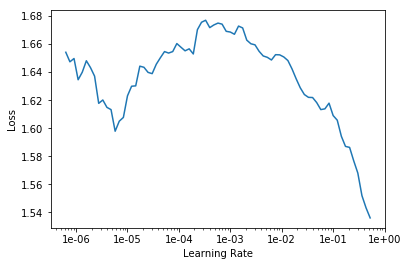

In [12]:
y_range = [0,5.5]
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [13]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.604140,0.607504,00:54
1,0.573011,0.575790,01:30
2,0.496891,0.550303,01:29
3,0.366228,0.536203,01:20
4,0.221546,0.536990,01:08


In [15]:
learn.save('dotprod')

In [17]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(13689, 40)
  (i_weight): Embedding(19645, 40)
  (u_bias): Embedding(13689, 1)
  (i_bias): Embedding(19645, 1)
)

In [18]:
g = review_df.groupby('beer_name')['review_overall'].count()
top_beers = g.sort_values(ascending=False).index.values[:1000]
top_beers[:10]

array(['Sierra Nevada Celebration Ale', '90 Minute IPA', 'India Pale Ale', 'Old Rasputin Russian Imperial Stout',
       'Two Hearted Ale', 'Sierra Nevada Pale Ale', 'Founders Breakfast Stout', 'Storm King Stout',
       'Stone Ruination IPA', 'Brooklyn Black Chocolate Stout'], dtype=object)

In [19]:
beer_bias = learn.weight(top_beers, is_item=True)
beer_bias.shape

torch.Size([1000, 40])

In [20]:
mean_ratings = review_df.groupby('beer_name')['review_overall'].mean()
beer_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_beers,beer_bias)]

In [21]:
beer_w = learn.weight(top_beers, is_item=True)
beer_w.shape

torch.Size([1000, 40])

In [22]:
beer_pca = beer_w.pca(2)
beer_pca.shape

torch.Size([1000, 2])

In [23]:
fac0,fac1 = beer_pca.t()
beer_comp = [(f, i) for f,i in zip(fac0, top_beers)]

In [24]:
top_beers
review_df[review_df['beer_name'].isin(top_beers)].groupby('beer_style').agg({'review_profilename' : lambda x: x.nunique()}).head()

,review_profilename
beer_style,
Altbier,175
American Adjunct Lager,996
American Amber / Red Ale,1434
American Amber / Red Lager,408
American Barleywine,956


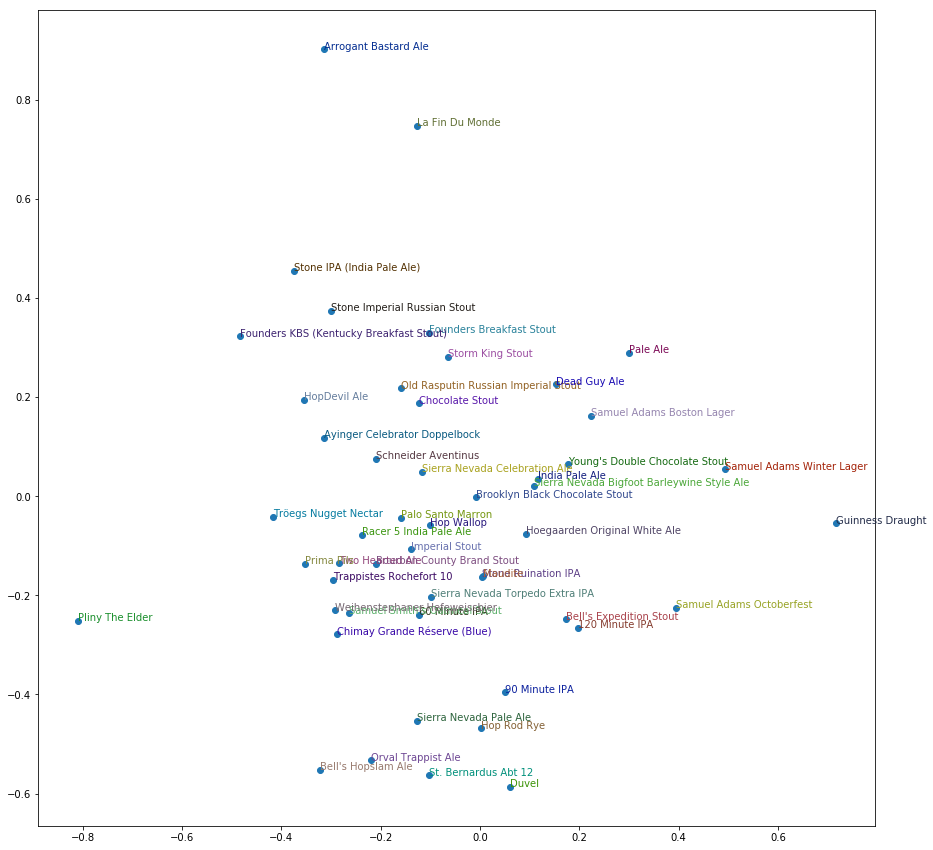

In [33]:
idxs = np.random.choice(len(top_beers), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_beers[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=10)
plt.show()

In [71]:
beer_and_style = []

# Iterate through each book
for beer in top_beers:
    # Iterate through the links in the book
    beer_and_style.extend((beer, beers_lookup[beers_lookup['beer_name']==beer]['beer_style']))
beer_and_style

['Old Rasputin Russian Imperial Stout', 125480    Russian Imperial Stout
 Name: beer_style, dtype: object, 'India Pale Ale', 6745      English India Pale Ale (IPA)
 10175     English India Pale Ale (IPA)
 20903                     American IPA
 21020                     American IPA
 21072                     American IPA
 21118                     American IPA
 24239                     American IPA
 27821                     American IPA
 34456     English India Pale Ale (IPA)
 37825                     American IPA
 39544                     American IPA
 43941                     American IPA
 46001                     American IPA
 47476                     American IPA
 52777     English India Pale Ale (IPA)
 59065     English India Pale Ale (IPA)
 71206                     American IPA
 73132                     American IPA
 73821                     American IPA
 74727                     American IPA
 75842                     American IPA
 79859     English India Pale Ale (I

In [69]:
beer_and_style[

125480    Russian Imperial Stout
Name: beer_style, dtype: object

In [48]:
top_beers[idxs]
beers_lookup = review_df[['beer_name', 'beer_beerid', 'beer_style', 'brewery_name']].drop_duplicates()
beers_lookup[beers_lookup['beer_name'].isin(top_beers[idxs])]
# review_df[review_df['beer_name'].isin(top_beers[idxs])]

,beer_name,beer_beerid,beer_style,brewery_name
657,Pale Ale,13009,American Pale Ale (APA),No-Li Brewhouse
975,Founders Breakfast Stout,11757,American Double / Imperial Stout,Founders Brewing Company
1228,Pale Ale,25656,American Pale Ale (APA),Yazoo Brewing Company
1395,Oatmeal Stout,73769,Oatmeal Stout,Mallinsons Brewing Company
3296,Founders KBS (Kentucky Breakfast Stout),19960,American Double / Imperial Stout,Founders Brewing Company
4106,Pale Ale,28951,American Pale Ale (APA),Mountaineer Brewing Co.
4148,Oatmeal Stout,6033,Oatmeal Stout,Tied House Cafe & Brewery
6745,India Pale Ale,36312,English India Pale Ale (IPA),Micro-Brasserie L'Alchimiste
6767,Pale Ale,24997,American Pale Ale (APA),Beck's Sports Brewery
7522,Sierra Nevada Celebration Ale,1904,American IPA,Sierra Nevada Brewing Co.


In [ ]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model,Sequential
 

In [ ]:
# beer_index = review_df['beer_beerid'].unique()
# user_index = review_df['beer_beerid'].unique()

In [ ]:
# def beer_embedding_model(embedding_size = 50, classification = False):
#     """Model to embed books and wikilinks using the functional API.
#        Trained to discern if a link is present in a article"""
    
#     # Both inputs are 1-dimensional
#     beer = Input(name = 'beer', shape = [1])
#     user = Input(name = 'user', shape = [1])
    
#     # Embedding the book (shape will be (None, 1, 50))
#     beer_embedding = Embedding(name = 'beer_embedding',
#                                input_dim = len(beers_index),
#                                output_dim = embedding_size)(beer)
    
#     # Embedding the link (shape will be (None, 1, 50))
#     user_embedding = Embedding(name = 'user_embedding',
#                                input_dim = len(users_index),
#                                output_dim = embedding_size)(user)
    
#     # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
#     merged = Dot(name = 'dot_product', normalize = True, axes = 2)([beer_embedding, user_embedding])
    
#     # Reshape to be a single number (shape will be (None, 1))
#     merged = Reshape(target_shape = [1])(merged)
    
#     # If classifcation, add extra layer and loss function is binary cross entropy
#     if classification:
#         merged = Dense(1, activation = 'sigmoid')(merged)
#         model = Model(inputs = [beer, user], outputs = merged)
#         model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
#     # Otherwise loss function is mean squared error
#     else:
#         model = Model(inputs = [beer, user], outputs = merged)
#         model.compile(optimizer = 'Adam', loss = 'mse')
    
#     return model

# # Instantiate model and show parameters
# model = beer_embedding_model()
# model.summary()